In [747]:
import torch
import torch.nn as nn
import math
import numpy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.model_selection import train_test_split
import torchmetrics

In [748]:
num_samples = 1000
X_m, y_m = make_moons(n_samples=num_samples, random_state=24, noise=0.05)

In [749]:
df = pd.DataFrame({"x1":X_m[:,0],
                   "x2":X_m[:,1],
                   "y":y_m
                  })
df.head()

,x1,x2,y
0,0.735642,0.776451,0
1,-0.737440,0.782403,0
2,1.967631,0.399281,1
3,-0.975513,0.102473,0
4,-0.991231,0.053749,0


In [750]:
df.y.value_counts()

y
0    500
1    500
Name: count, dtype: int64

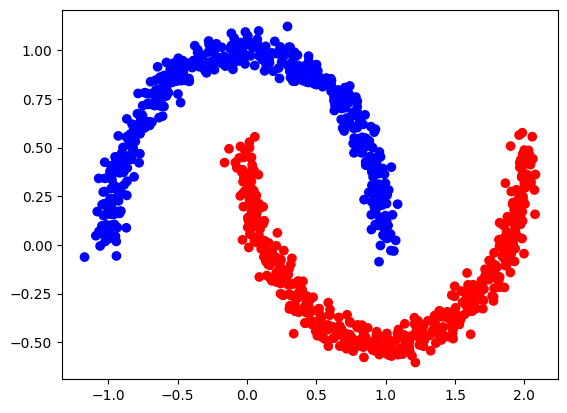

In [751]:
plt.scatter(x=X_m[:,0], y=X_m[:,1], c = y_m, cmap=plt.cm.bwr)

In [752]:
X_m.shape, y_m.shape

((1000, 2), (1000,))

In [753]:
X = torch.from_numpy(X_m).type(torch.float)
y = torch.from_numpy(y_m).type(torch.float)
X, y

(tensor([[ 0.7356,  0.7765],
         [-0.7374,  0.7824],
         [ 1.9676,  0.3993],
         ...,
         [ 0.3368,  0.8998],
         [ 1.7843, -0.1110],
         [-0.8943,  0.5007]]),
 tensor([0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
         0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
         0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,


In [754]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=24, shuffle=True)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

##### For Both Windows & Mac



In [755]:
DEVICE = 'cuda' if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else 'cpu')
DEVICE

device(type='mps')

In [756]:
class CircleClassifier(nn.Module):
    def __init__(self, hidden_units=10):
        super().__init__()
        self.l_first = nn.Linear(in_features=2, out_features=hidden_units)
        self.l1 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.l2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        # self.l3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.l_last = nn.Linear(in_features=hidden_units, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # return self.l_last(self.relu(self.l1(self.relu(self.l_first(x)))))
        return self.l_last(self.relu(self.l2(self.relu(self.l1(self.relu(self.l_first(x)))))))

model = CircleClassifier().to(device=DEVICE)

model_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features=5, out_features=1),
    nn.ReLU()
).to(DEVICE)

In [757]:
# model.l_first.state_dict()['weight'].shape

In [758]:
model_seq.state_dict, model.state_dict

(<bound method Module.state_dict of Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): ReLU()
   (2): Linear(in_features=5, out_features=5, bias=True)
   (3): ReLU()
   (4): Linear(in_features=5, out_features=1, bias=True)
   (5): ReLU()
 )>,
 <bound method Module.state_dict of CircleClassifier(
   (l_first): Linear(in_features=2, out_features=10, bias=True)
   (l1): Linear(in_features=10, out_features=10, bias=True)
   (l2): Linear(in_features=10, out_features=10, bias=True)
   (l_last): Linear(in_features=10, out_features=1, bias=True)
   (relu): ReLU()
 )>)

In [759]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.5)

In [760]:
def accuracy(y_pred, y):
    return int(torch.sum(y_pred==y)/len(y))

In [761]:
def accuracy_fn(y_true, y_pred):
    return torchmetrics.functional.accuracy(preds=y_pred, target=y_true, task='binary')
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [762]:
epochs = 1000

X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

for epoch in range(epochs):
    model.train()

    y_logits = model.forward(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    a = accuracy(y_pred=y_pred, y=y_train)
    a_nm = accuracy_fn(y_pred=y_pred, y_true=y_train)
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()

    if epoch % int(epochs/10) == 0:

        test_logits = model.forward(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(test_logits))
        test_accuracy = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

        print(f"Epoch {epoch} | Loss: {loss:.4f} | Train Accuracy: {a_nm} | Test Accuracy: {test_accuracy}")
    
    

Epoch 0 | Loss: 0.7016 | Train Accuracy: 0.5062500238418579 | Test Accuracy: 0.4749999940395355
Epoch 100 | Loss: 0.1713 | Train Accuracy: 0.9487500190734863 | Test Accuracy: 0.9700000286102295
Epoch 200 | Loss: 0.0032 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 300 | Loss: 0.0013 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 400 | Loss: 0.0008 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 500 | Loss: 0.0006 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 600 | Loss: 0.0004 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 700 | Loss: 0.0003 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 800 | Loss: 0.0003 | Train Accuracy: 1.0 | Test Accuracy: 1.0
Epoch 900 | Loss: 0.0002 | Train Accuracy: 1.0 | Test Accuracy: 1.0


In [763]:

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


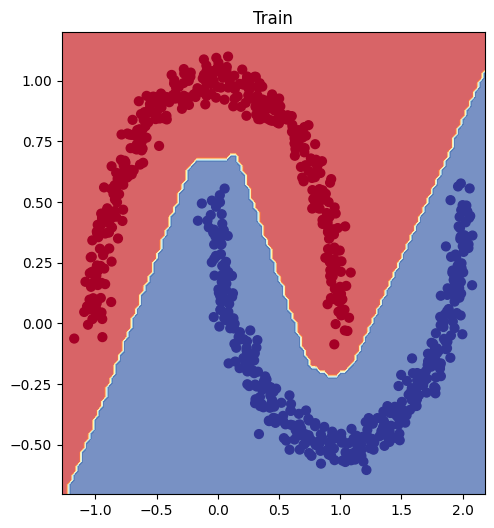

In [764]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)


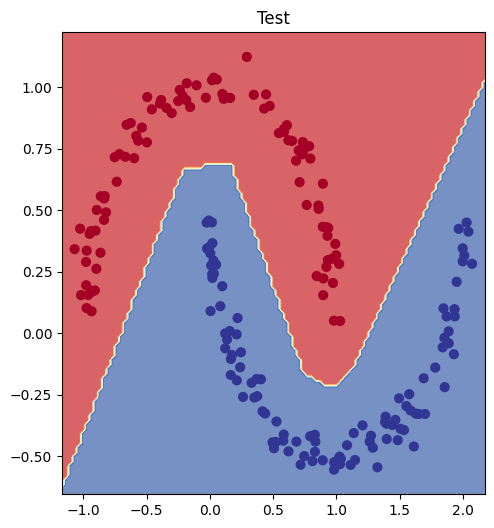

In [765]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
